In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib

In [4]:
data_dir='/home/grace/Documents/some/data_dir'
data_dir = pathlib.Path(data_dir)

In [5]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

168


In [6]:
batch_size = 32
img_height = 180
img_width = 180

In [7]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 168 files belonging to 2 classes.
Using 135 files for training.


In [8]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 168 files belonging to 2 classes.
Using 33 files for validation.


In [9]:
class_names = train_ds.class_names
print(class_names)

['five', 'ten']


In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [11]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [13]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image)) 

0.0005446357 1.0


In [14]:
num_classes = 2

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [15]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      447       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

In [17]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
5/5 [==============================] - 10s 2s/step - loss: 0.8216 - accuracy: 0.4623 - val_loss: 0.5326 - val_accuracy: 0.7576
Epoch 2/10
5/5 [==============================] - 3s 576ms/step - loss: 0.6604 - accuracy: 0.5983 - val_loss: 0.5430 - val_accuracy: 0.7576
Epoch 3/10
5/5 [==============================] - 3s 702ms/step - loss: 0.5749 - accuracy: 0.7133 - val_loss: 0.4523 - val_accuracy: 0.8182
Epoch 4/10
5/5 [==============================] - 3s 579ms/step - loss: 0.4775 - accuracy: 0.8091 - val_loss: 0.3330 - val_accuracy: 0.8788
Epoch 5/10
5/5 [==============================] - 3s 577ms/step - loss: 0.3853 - accuracy: 0.8737 - val_loss: 0.3496 - val_accuracy: 0.9697
Epoch 6/10
5/5 [==============================] - 3s 575ms/step - loss: 0.3417 - accuracy: 0.8745 - val_loss: 0.2412 - val_accuracy: 0.9697
Epoch 7/10
5/5 [==============================] - 3s 725ms/step - loss: 0.1870 - accuracy: 0.9610 - val_loss: 0.1507 - val_accuracy: 0.9394
Epoch 8/10
5/5 [======

In [33]:
model.save('/home/grace/Documents/Project/saved_model/model.h5')

In [26]:
img_url = "/home/grace/Documents/Final_Project/data/8.jpg"
img_path = tf.keras.utils.get_file('Image', origin=img_url)

img = keras.preprocessing.image.load_img(
    img_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to five with a 99.83 percent confidence.


In [28]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


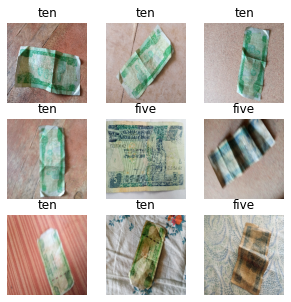

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")